In [ ]:
# === YouTube Wayback Subscribers: robust, single-run notebook version ===
# Dependencies: requests, pandas, tqdm, urllib3, matplotlib (and optionally scipy if you later use PCHIP)
# pip install requests pandas tqdm urllib3 matplotlib

import re, html, time
from typing import Optional, List, Dict
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
# -----------------------------
# 0) Scraper helpers
# -----------------------------

def make_session(user_agent: str = "yt-wayback-scraper/1.1 (+contact@example.com)") -> requests.Session:
    s = requests.Session()
    s.headers.update({"User-Agent": user_agent})
    retry = Retry(
        total=8, connect=5, read=5, backoff_factor=1.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=("GET",),
        raise_on_status=False,
        respect_retry_after_header=True,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    return s

def build_channel_url_variants(channel_id: str, include_about=True, include_featured=True, include_locale=True) -> List[str]:
    """
    Generate several URL variants for the same channel; some months only parse on certain paths.
    """
    base = f"https://www.youtube.com/channel/{channel_id}"
    urls = [base]
    if include_about:
        urls += [f"{base}/about"]
    if include_featured:
        urls += [f"{base}/featured"]
    if include_locale:
        urls += [f"{base}?hl=en", f"{base}/about?hl=en&ucbcb=1"]
    return urls

def list_snapshots_multi(urls: List[str], start_year: int = 2010, end_year: Optional[int] = None) -> pd.DataFrame:
    """
    Query Wayback CDX for *all* given URL variants, no collapse.
    Returns columns: ['timestamp','orig','status','dt','month','year'].
    """
    if end_year is None:
        end_year = pd.Timestamp.utcnow().year

    all_df = []
    base = "https://web.archive.org/cdx/search/cdx"
    for u in urls:
        params = {
            "url": u,
            "output": "json",
            # not forcing 200; id_/ fetch often resolves banners/redirects
            "from": start_year,
            "to": end_year,
            "matchType": "prefix",
        }
        r = requests.get(base, params=params, timeout=30)
        if not r.ok:
            continue
        rows = r.json()
        if rows and len(rows) > 1:
            df = pd.DataFrame(rows[1:], columns=["urlkey","timestamp","orig","mime","status","digest","length"])
            df = df[["timestamp","orig","status"]].copy()
            df["dt"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S", utc=True).dt.tz_convert(None)
            all_df.append(df)

    if not all_df:
        return pd.DataFrame(columns=["timestamp","orig","status","dt","month","year"])

    snaps = pd.concat(all_df, ignore_index=True)
    snaps = snaps.sort_values("dt").reset_index(drop=True)
    snaps["year"] = snaps["dt"].dt.year
    snaps["month"] = snaps["dt"].dt.to_period("M")
    return snaps

def fetch_wayback_html(session: requests.Session, ts: str, orig: str, read_timeout: int = 60) -> str:
    """
    Download raw HTML for a specific (timestamp, original URL) pair using Wayback's id_/ to skip UI banner.
    """
    url = f"https://web.archive.org/web/{ts}id_/{orig}"
    r = session.get(url, timeout=(8, read_timeout))
    r.raise_for_status()
    return r.text

# -----------------------------
# 1) Parsing helpers
# -----------------------------

# JSON first, then HTML fallbacks (handles multiple eras/locales)
JSON_PATTERNS = [
    re.compile(r'"subscriberCountText"\s*:\s*{\s*"simpleText"\s*:\s*"([^"]+)"', re.S),
    re.compile(r'"approximateSubscriberCount"\s*:\s*"([^"]+)"', re.S),
    re.compile(r'"subscriberCountText"\s*:\s*{\s*"runs"\s*:\s*\[\s*{\s*"text"\s*:\s*"([^"]+)"', re.S),
]
HTML_PATTERNS = [
    re.compile(r'yt-subscription-button-subscriber-count[^>]*>([^<]+)</', re.I),
    re.compile(r'([\d\.,\sA-Za-z]{1,24})\s*subscribers?', re.I),
    re.compile(r'([\d\.,\sA-Za-z]{1,24})\s*(abonnés|abonné|suscriptores|iscritti|abonnenten)', re.I),
]

def human_to_int(raw: str) -> int:
    """
    Convert "10.8K", "1.3M", "200 thousand", "260ksubscribers", etc. → int.
    """
    s = html.unescape(raw).strip().lower()
    s = re.sub(r"(subscribers?|abonnés|abonné|suscriptores|iscritti|abonnenten)\b", "", s)
    s = s.replace(",", "").replace(" ", "")
    s = s.replace("thousand", "k").replace("million", "m").replace("billion", "b")
    m = re.fullmatch(r"([0-9]*\.?[0-9]+)([kmb])?", s)
    if not m:
        raise ValueError(f"can't parse subscriber count: {raw!r}")
    num = float(m.group(1))
    mult = {"k": 1_000, "m": 1_000_000, "b": 1_000_000_000}.get(m.group(2), 1)
    return int(round(num * mult))

def extract_subs(html_text: str) -> Optional[int]:
    """
    Look for subscriber count in the page HTML.
    Prefer structured JSON near channel header; fallback to HTML patterns.
    """
    h = html_text
    header_window = None
    key = "c4TabbedHeaderRenderer"  # anchor near channel header JSON
    i = h.find(key)
    if i != -1:
        header_window = h[max(0, i - 3000): i + 8000]

    spaces = [w for w in (header_window, h) if w]

    for space in spaces:
        for pat in JSON_PATTERNS:
            m = pat.search(space)
            if m:
                try:
                    return human_to_int(m.group(1))
                except ValueError:
                    pass

    for space in spaces:
        for pat in HTML_PATTERNS:
            m = pat.search(space)
            if m:
                try:
                    return human_to_int(m.group(1))
                except ValueError:
                    pass
    return None

# -----------------------------
# 2) Adaptive, multi-variant scraper
# -----------------------------

def scrape_wayback_subs_adaptive(
    channel_id: str,
    start_year: int = 2010,
    end_year: Optional[int] = None,
    target_per_month: int = 2,
    max_attempts_per_month: int = 25,
    per_month_overrides: Optional[Dict[int, int]] = None,   # e.g., {2021: 10, 2022: 10}
    include_about: bool = True,
    include_featured: bool = True,
    include_locale: bool = True,
    sleep_between: float = 0.8,
    read_timeout: int = 40,
    show_progress: bool = True,
) -> pd.DataFrame:
    """
    One-pass adaptive scraper with multi-URL variants.
      - Build a pool of captures across channel URL variants (/, /about, /featured, ?hl=en…).
      - For each month (earliest→latest), attempt captures across all variants:
          Collect up to target_per_month successful parses for that month (or per-year override).
          Stop early for that month once target is met or attempts exceed max_attempts_per_month.
      - Returns deduped rows: date, subscribers, source='wayback'.
    """
    urls = build_channel_url_variants(channel_id, include_about, include_featured, include_locale)
    snaps = list_snapshots_multi(urls, start_year, end_year)
    if snaps.empty:
        return pd.DataFrame(columns=["date", "subscribers", "source"])

    sess = make_session()

    def tgt(year: int) -> int:
        if per_month_overrides and (year in per_month_overrides):
            return per_month_overrides[year]
        return target_per_month

    out_rows = []
    months = snaps["month"].unique().tolist()
    iterator = tqdm(months, desc="Months", unit="mo") if show_progress else months

    for m in iterator:
        m_df = snaps[snaps["month"] == m].sort_values("dt")
        y = int(m.start_time.year)
        target = tgt(y)

        successes = 0
        attempts  = 0

        # Iterate captures for this month across all variants
        for ts, orig in m_df[["timestamp","orig"]].itertuples(index=False):
            if successes >= target or attempts >= max_attempts_per_month:
                break
            attempts += 1
            try:
                html_txt = fetch_wayback_html(sess, ts, orig, read_timeout=read_timeout)
                subs = extract_subs(html_txt)
                if subs is not None:
                    out_rows.append({
                        "date": pd.to_datetime(ts[:8], format="%Y%m%d"),
                        "subscribers": int(subs),
                        "source": "wayback",
                    })
                    successes += 1
            except requests.exceptions.ReadTimeout:
                pass
            except requests.HTTPError:
                pass
            except Exception:
                pass
            time.sleep(sleep_between)

    df = pd.DataFrame(out_rows)
    if df.empty:
        return df

    # Deduplicate: keep max per day (guards tiny parsing jitter)
    df = (df.groupby("date", as_index=False)["subscribers"].max()
            .sort_values("date")
            .reset_index(drop=True))
    return df

# -----------------------------
# 3) Cleaning & optional daily series
# -----------------------------

def clean_wayback_series(
    df: pd.DataFrame,
    drop_large_dips: bool = True,
    dip_threshold: float = 0.7,
    enforce_monotone: bool = True
) -> pd.DataFrame:
    """
    Remove obvious mis-parses (huge drops) and optionally enforce non-decreasing subs.
    - drop_large_dips: drop rows < dip_threshold * prior_max (e.g., 0.7 = drop 30%+ dips)
    - enforce_monotone: replace series with cumulative max
    """
    if df.empty:
        return df.copy()
    df = df.sort_values("date").reset_index(drop=True)

    if drop_large_dips:
        keep = []
        max_so_far = -1
        for _, row in df.iterrows():
            s = int(row["subscribers"])
            if max_so_far >= 0 and s < dip_threshold * max_so_far:
                continue  # suspicious drop
            keep.append(row)
            if s > max_so_far:
                max_so_far = s
        df = pd.DataFrame(keep)

    if enforce_monotone and not df.empty:
        df["subscribers"] = df["subscribers"].cummax()

    return df.reset_index(drop=True)

def to_daily_filled(df: pd.DataFrame, method: str = "step") -> pd.DataFrame:
    """
    Convert sparse series to daily frequency.
    method: 'step' -> forward-fill (conservative)
            'linear' -> time interpolation + cummax guard
            'logexp' -> log-space linear interpolation + cummax guard
    """
    if df.empty:
        return df.copy()
    s = df.set_index("date").sort_index()

    if method == "step":
        out = s.asfreq("D").ffill()

    elif method == "linear":
        out = s.asfreq("D")
        out["subscribers"] = (out["subscribers"]
                              .interpolate(method="time")
                              .round().astype("Int64"))
        out["subscribers"] = out["subscribers"].cummax()

    elif method == "logexp":
        # interpolate on log scale then exponentiate
        import numpy as np
        s_pos = s[s["subscribers"] > 0].copy()
        out = s_pos.asfreq("D")
        out["log_subs"] = np.log(out["subscribers"])
        out["log_subs"] = out["log_subs"].interpolate(method="time")
        out["subscribers"] = np.exp(out["log_subs"]).round().astype(int)
        out = out.drop(columns=["log_subs"])
        out["subscribers"] = out["subscribers"].cummax()
    else:
        raise ValueError("method must be one of: 'step', 'linear', 'logexp'")

    out["source"] = out.get("source", pd.Series(index=out.index, dtype=object)).fillna(f"filled_{method}")
    return out.reset_index()


In [ ]:
def df_to_azure_sql(df):
    """
    Write/append the dataframe into dbo.youtube_videos (Azure SQL DB)
    """

    drv = "ODBC Driver 18 for SQL Server"            # keep spaces!
    odbc_str = (
        f"Driver={drv};Server=tcp:{os.getenv('AZSQL_SERVER')},1433;"
        f"Database={os.getenv('AZSQL_DATABASE')};"
        f"Uid={os.getenv('AZSQL_USERNAME')};"
        f"Pwd={os.getenv('AZSQL_PASSWORD')};"
        "Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
    )

    # SQLAlchemy-style URL.  Space → + ;  parentheses → %28 %29, etc.
    params = quote_plus(odbc_str)
    engine = create_engine(
        f"mssql+pyodbc:///?odbc_connect={params}",
        fast_executemany=True        # batches rows under the hood
    )

    # —— upsert strategy: try append-only, let PK skip duplicates
    with engine.begin() as cn:
        df.to_sql(
            name="Vaush_VIDEOS",
            con=cn,
            schema="YOUTUBE_API",
            if_exists="append",       # create once, then append
            index=False,
            chunksize=1000,           # good balance of  network / TX
        )

Months: 100%|██████████| 73/73 [13:53<00:00, 11.42s/mo]

Saved sparse series: 45 rows → subs_wayback_sparse.csv
Saved daily series: 2272 rows → subs_wayback_daily.csv


,date,subscribers
35,2024-03-05,471000
36,2024-03-19,471000
37,2024-04-08,471000
38,2024-05-09,471000
39,2024-06-01,471000
40,2024-06-06,471000
41,2025-01-07,503000
42,2025-03-06,523000
43,2025-06-04,540000
44,2025-07-04,549000


,date,subscribers,source
2262,2025-06-25,546300,filled_linear
2263,2025-06-26,546600,filled_linear
2264,2025-06-27,546900,filled_linear
2265,2025-06-28,547200,filled_linear
2266,2025-06-29,547500,filled_linear
2267,2025-06-30,547800,filled_linear
2268,2025-07-01,548100,filled_linear
2269,2025-07-02,548400,filled_linear
2270,2025-07-03,548700,filled_linear
2271,2025-07-04,549000,filled_linear


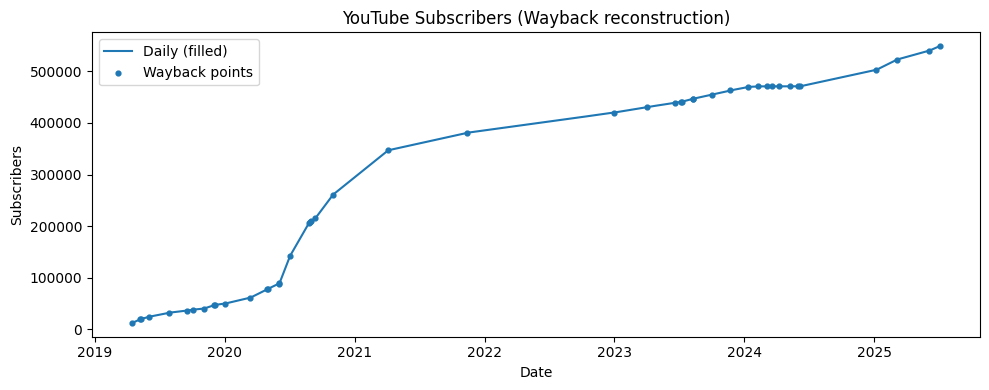

In [4]:
# -----------------------------
# 4) PARAMETERS (edit these)
# -----------------------------

CHANNEL_ID   = "UC1E-JS8L0j1Ei70D9VEFrPQ"   # <-- PUT REAL CHANNEL ID
START_YEAR   = 2019
END_YEAR     = 2025

# Adaptive sampling: default, then per-year overrides
TARGET_PER_MONTH         = 2           # successes per month (typical months)
PER_MONTH_OVERRIDES      = {2021: 10, 2022: 10}  # denser for your sparse years
MAX_ATTEMPTS_PER_MONTH   = 25          # hard cap on tries per month
SLEEP_SEC                = 0.9
READ_TIMEOUT             = 45
INCLUDE_ABOUT            = True
INCLUDE_FEATURED         = True
INCLUDE_LOCALE           = True

# Cleaning + output
DROP_DIP     = True
DIP_THRESH   = 0.70
ENFORCE_MONO = True
DAILY_METHOD = "linear"                # 'step'|'linear'|'logexp'
CSV_SPARSE   = "subs_wayback_sparse.csv"
CSV_DAILY    = "subs_wayback_daily.csv"

# -----------------------------
# 5) RUN: scrape → clean → (optional) daily → save → plot
# -----------------------------

wb_raw = scrape_wayback_subs_adaptive(
    channel_id=CHANNEL_ID,
    start_year=START_YEAR,
    end_year=END_YEAR,
    target_per_month=TARGET_PER_MONTH,
    max_attempts_per_month=MAX_ATTEMPTS_PER_MONTH,
    per_month_overrides=PER_MONTH_OVERRIDES,
    include_about=INCLUDE_ABOUT,
    include_featured=INCLUDE_FEATURED,
    include_locale=INCLUDE_LOCALE,
    sleep_between=SLEEP_SEC,
    read_timeout=READ_TIMEOUT,
    show_progress=True,
)

wb_clean = clean_wayback_series(
    wb_raw,
    drop_large_dips=DROP_DIP,
    dip_threshold=DIP_THRESH,
    enforce_monotone=ENFORCE_MONO
)

# Save sparse series
if not wb_clean.empty:
    wb_clean.to_csv(CSV_SPARSE, index=False)
    print(f"Saved sparse series: {len(wb_clean)} rows → {CSV_SPARSE}")
else:
    print("No data scraped—check channel ID or date range.")

# Optional: daily series
daily = to_daily_filled(wb_clean, method=DAILY_METHOD)
if not daily.empty:
    daily.to_csv(CSV_DAILY, index=False)
    print(f"Saved daily series: {len(daily)} rows → {CSV_DAILY}")

# Quick looks
display(wb_clean.tail(10))
display(daily.tail(10))

# Plot sparse (points) + daily (line)
plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["subscribers"], label="Daily (filled)")
plt.scatter(wb_clean["date"], wb_clean["subscribers"], s=12, label="Wayback points")
plt.title("YouTube Subscribers (Wayback reconstruction)")
plt.xlabel("Date"); plt.ylabel("Subscribers")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
daily.to_csv("subs_wayback.csv",index=False)